In [1]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

import acquire

In [2]:
df = acquire.wrangle_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900222 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ip           900222 non-null  object 
 1   endpoint     900222 non-null  object 
 2   user_id      900222 non-null  int64  
 3   cohort_id    847329 non-null  float64
 4   cohort_name  847329 non-null  object 
 5   slack        847329 non-null  object 
 6   start_date   847329 non-null  object 
 7   end_date     847329 non-null  object 
 8   program_id   847329 non-null  float64
 9   program      847329 non-null  object 
 10  module       849909 non-null  object 
 11  lesson       681558 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 89.3+ MB


# Enforcement Policy Question
At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off.   
Do you see any evidence of that happening? Did it happen before?

## How do we know if they are accessing something that belongs to their program?

In [3]:
df.head()

,ip,endpoint,user_id,cohort_id,cohort_name,slack,start_date,end_date,program_id,program,module,lesson
datetime,,,,,,,,,,,,
2018-01-26 09:55:03,97.105.19.61,/,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack PHP,None,None
2018-01-26 09:56:02,97.105.19.61,java-ii,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack PHP,java-ii,None
2018-01-26 09:56:05,97.105.19.61,java-ii/object-oriented-programming,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack PHP,java-ii,object-oriented-programming
2018-01-26 09:56:06,97.105.19.61,slides/object_oriented_programming,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack PHP,slides,object_oriented_programming
2018-01-26 09:56:24,97.105.19.61,javascript-i/conditionals,2,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack Java,javascript-i,conditionals


In [4]:
mod_prog = df.groupby('module').program.value_counts()
mod_prog

module                         program        
%20https:                      Data Science        1
'                              Full Stack Java     1
,%20https:                     Data Science        1
.git                           Full Stack Java     1
.gitignore                     Data Science        1
                                                  ..
where                          Data Science        1
working-with-time-series-data  Data Science       14
                               Full Stack Java     1
wp-admin                       Full Stack Java     1
wp-login                       Full Stack Java     1
Name: program, Length: 834, dtype: int64

In [5]:
{"working-with-time-series-data" : "Data Science"}

{'working-with-time-series-data': 'Data Science'}

In [6]:
mod_prog.idxmax()

('javascript-i', 'Full Stack Java')

In [7]:
a = mod_prog.rename('vcount').reset_index()

In [8]:
out = {}
for i, mod in enumerate(a.module.unique().tolist()):
    this = a[a.module == mod]
    out[i] = {'module':mod, 'parent':this.set_index('program').vcount.idxmax()}

pd.DataFrame.from_dict(out, orient='index')

,module,parent
0,%20https:,Data Science
1,',Full Stack Java
2,",%20https:",Data Science
3,.git,Full Stack Java
4,.gitignore,Data Science
...,...,...
681,web-dev-day-two,Full Stack Java
682,where,Data Science
683,working-with-time-series-data,Data Science
684,wp-admin,Full Stack Java


In [9]:
def build_module_parent_df(df):
    mod_prog = df.groupby('module').program.value_counts()
    a = mod_prog.rename('vcount').reset_index()
    out = {}
    for i, mod in enumerate(a.module.unique().tolist()):
        this = a[a.module == mod]
        out[i] = {'module':mod, 'module_parent':this.set_index('program').vcount.idxmax()}

    return pd.DataFrame.from_dict(out, orient='index')

In [10]:
parents = build_module_parent_df(df)

In [11]:
df = df.reset_index().merge(parents, how='left', on='module').set_index('datetime')

In [12]:
df.program.str.contains('Full Stack')

datetime
2018-01-26 09:55:03    True
2018-01-26 09:56:02    True
2018-01-26 09:56:05    True
2018-01-26 09:56:06    True
2018-01-26 09:56:24    True
                       ... 
2021-04-21 16:41:51    True
2021-04-21 16:42:02    True
2021-04-21 16:42:09    True
2021-04-21 16:44:37    True
2021-04-21 16:44:39    True
Name: program, Length: 900222, dtype: object

In [13]:
xf = df.dropna()

In [14]:
xf.loc[xf.program.str.contains('Full Stack'), 'program'] = 'Full Stack'
xf.loc[xf.module_parent.str.contains('Full Stack'), 'module_parent'] = 'Full Stack'

In [15]:
xf.head()

,ip,endpoint,user_id,cohort_id,cohort_name,slack,start_date,end_date,program_id,program,module,lesson,module_parent
datetime,,,,,,,,,,,,,
2018-01-26 09:56:05,97.105.19.61,java-ii/object-oriented-programming,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack,java-ii,object-oriented-programming,Full Stack
2018-01-26 09:56:06,97.105.19.61,slides/object_oriented_programming,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack,slides,object_oriented_programming,Full Stack
2018-01-26 09:56:24,97.105.19.61,javascript-i/conditionals,2,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,javascript-i,conditionals,Full Stack
2018-01-26 09:56:41,97.105.19.61,javascript-i/loops,2,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,javascript-i,loops,Full Stack
2018-01-26 09:56:46,97.105.19.61,javascript-i/conditionals,3,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,javascript-i,conditionals,Full Stack


In [18]:
xf['unauth_acc'] = xf.program != xf.module_parent
xf.head()

C:\Users\Crux\AppData\Local\Temp\ipykernel_20788\2356600182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xf['unauth_acc'] = xf.program != xf.module_parent


,ip,endpoint,user_id,cohort_id,cohort_name,slack,start_date,end_date,program_id,program,module,lesson,module_parent,unauth_acc
datetime,,,,,,,,,,,,,,
2018-01-26 09:56:05,97.105.19.61,java-ii/object-oriented-programming,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack,java-ii,object-oriented-programming,Full Stack,False
2018-01-26 09:56:06,97.105.19.61,slides/object_oriented_programming,1,8.0,Hampton,#hampton,2015-09-22 00:00:00,2016-02-06 00:00:00,1.0,Full Stack,slides,object_oriented_programming,Full Stack,False
2018-01-26 09:56:24,97.105.19.61,javascript-i/conditionals,2,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,javascript-i,conditionals,Full Stack,False
2018-01-26 09:56:41,97.105.19.61,javascript-i/loops,2,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,javascript-i,loops,Full Stack,False
2018-01-26 09:56:46,97.105.19.61,javascript-i/conditionals,3,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,javascript-i,conditionals,Full Stack,False


<AxesSubplot:xlabel='datetime'>

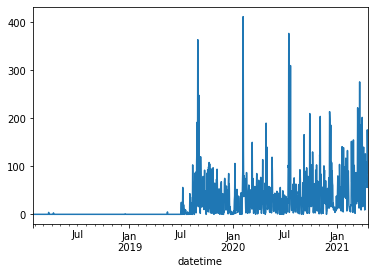

In [20]:
xf.unauth_acc.resample('D').sum().plot()

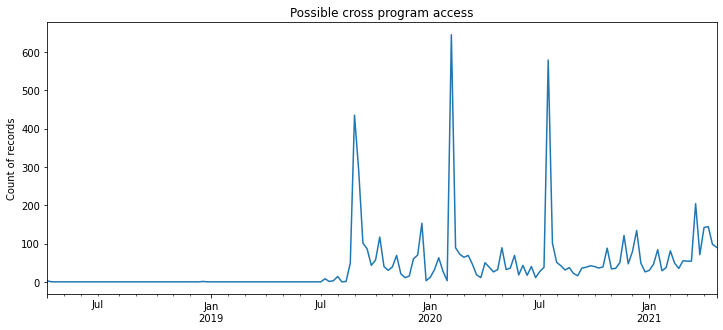

In [42]:
plt.figure(figsize=(12,5))
xf[xf.unauth_acc & (xf.program != 'Front-End') & (xf.cohort_name != 'Staff')].unauth_acc.resample('W').sum().plot()
plt.title('Possible cross program access')
plt.ylabel('Count of records')
plt.xlabel(None)
plt.savefig('2019_change.png', bbox_inches='tight')

In [27]:
xf[xf.unauth_acc & (xf.program != 'Front-End') & (xf.cohort_name != 'Staff')]

,ip,endpoint,user_id,cohort_id,cohort_name,slack,start_date,end_date,program_id,program,module,lesson,module_parent,unauth_acc
datetime,,,,,,,,,,,,,,
2018-04-08 13:56:25,70.123.231.211,fundamentals/controllers,155,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,fundamentals,controllers,Data Science,True
2018-04-08 13:56:31,70.123.231.211,fundamentals/controllers,155,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,fundamentals,controllers,Data Science,True
2018-04-08 13:56:38,70.123.231.211,fundamentals/views,155,22.0,Teddy,#teddy,2018-01-08 00:00:00,2018-05-17 00:00:00,2.0,Full Stack,fundamentals,views,Data Science,True
2018-12-17 16:41:11,104.53.215.21,fundamentals/controllers,33,21.0,Sequoia,#sequoia,2017-09-27 00:00:00,2018-02-15 00:00:00,2.0,Full Stack,fundamentals,controllers,Data Science,True
2019-07-11 13:59:55,24.243.59.161,1-fundamentals/1-fundamentals-overview,186,24.0,Voyageurs,#voyageurs,2018-05-29 00:00:00,2018-10-11 00:00:00,2.0,Full Stack,1-fundamentals,1-fundamentals-overview,Data Science,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 08:34:10,96.8.130.134,search/search_index.json,692,59.0,Darden,#darden,2020-07-13 00:00:00,2021-01-12 00:00:00,3.0,Data Science,search,search_index.json,Full Stack,True
2021-04-21 10:40:06,99.147.232.101,search/search_index.json,898,137.0,Florence,#florence,2021-03-15 00:00:00,2021-09-03 00:00:00,3.0,Data Science,search,search_index.json,Full Stack,True
2021-04-21 10:54:33,99.158.249.67,appendix/professional-development/t-block-less...,838,133.0,Easley,#easley,2020-12-07 00:00:00,2021-06-08 00:00:00,3.0,Data Science,appendix,professional-development,Full Stack,True


In [30]:
xf[xf.program_id == 3].index.min(), xf[xf.program_id == 3].index.max()

(Timestamp('2019-08-20 09:40:28'), Timestamp('2021-04-21 16:32:50'))

In [31]:
xf[xf.unauth_acc & (xf.program != 'Front-End') & (xf.cohort_name != 'Staff')].module.value_counts()

appendix                3938
search                  2203
1-fundamentals           175
4-python                  53
fundamentals              46
3-sql                     18
2-storytelling            14
6-regression              11
10-anomaly-detection      10
html-css                  10
python                    10
5-stats                    6
javascript-i               2
classification             2
sql                        2
7-classification           2
spring                     2
13-advanced-topics         2
11-nlp                     2
mkdocs                     1
git                        1
grades                     1
java-ii                    1
java-i                     1
nlp                        1
Name: module, dtype: int64